# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Gabriella Yoanda Pelawi
- **Email:** mc008d5x2466@student.devacademy.id
- **ID Dicoding:** MC008D5X2466
- **Sumber Dataset** : https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset/data?select=Vegetable+Images

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import cv2
from PIL import Image, ImageFilter
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gabriellayoanda","key":"f207582293cb5c6fcc292ead2c1c8321"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

Menggabungkan data train dan data test ke direktori yang sama.

In [ ]:
# Direktori awal untuk train dan test
train_dir = "Vegetable Images/train"
test_dir = "Vegetable Images/test"

# Direktori baru untuk dataset gabungan
combined_dir = "Vegetable Images/dataset"
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### Dataset Checking

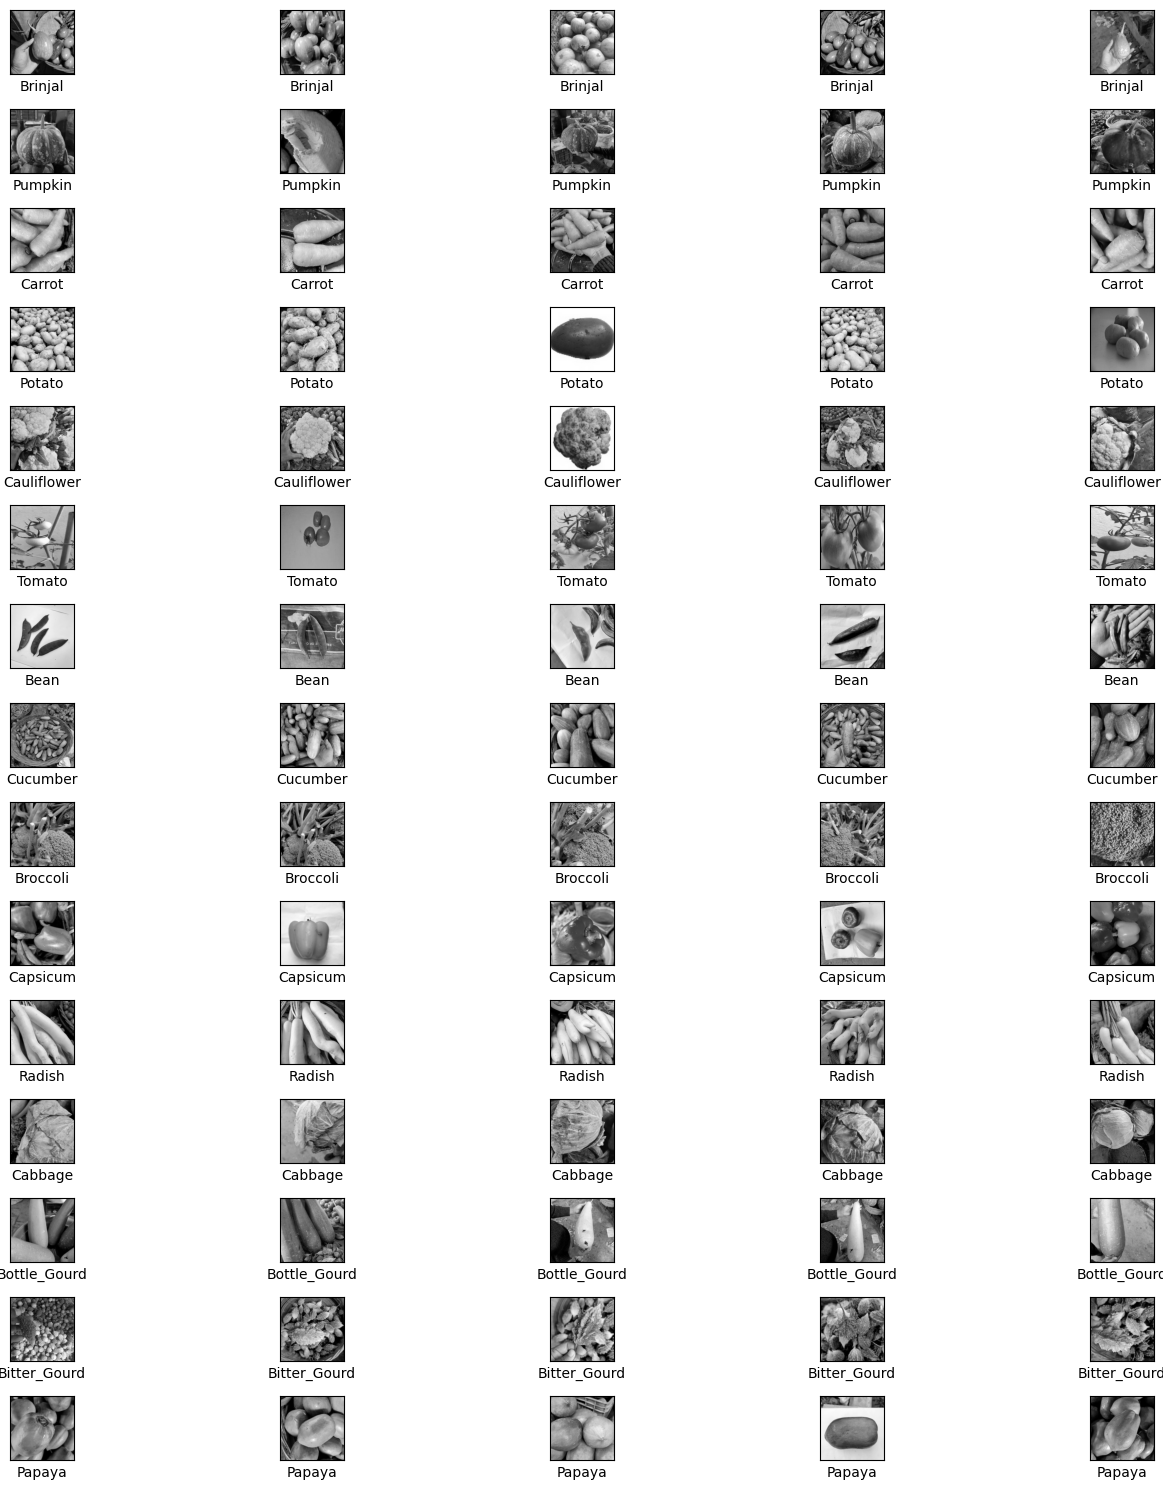

In [ ]:
vegetable_image = {}

# Path sumber train
path = "Vegetable Images/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    vegetable_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data.
path_sub = "Vegetable Images/dataset/"

fig, axs = plt.subplots(len(vegetable_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(vegetable_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Plot Distribusi

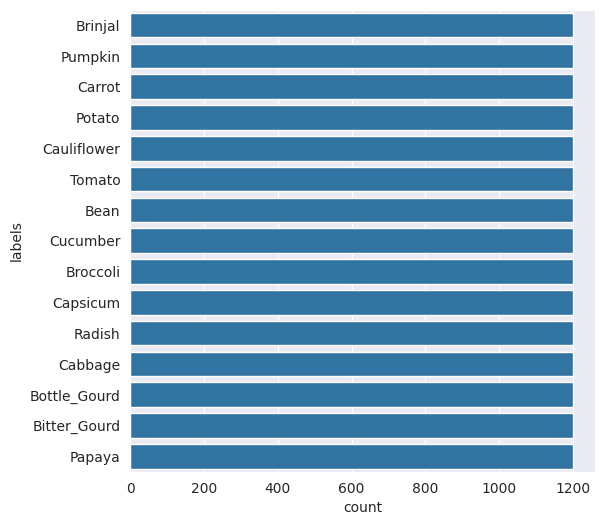

In [ ]:
# Source path
vegetable_path = "Vegetable Images/dataset/"

file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(vegetable_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Data terdiri atas 15 kelas dimana masing-masing kelas terdiri dari 1200 gambar.

### Data Augmentation

Dilakukan data augmentasi untuk membuat variasi baru dari setiap gambar dalam dataset.

In [ ]:
# Function to apply different transformations

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotate 90, 180, or 270 degrees randomly
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = Image.fromarray((img.numpy() * 255).astype(np.uint8))
    img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(1, 3)))
    img = np.array(img)
    img = img / 255.0
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Vegetable Images/dataset"
augmented_path = "Vegetable Images/dataset_augmented"
os.makedirs(augmented_path, exist_ok=True)

images = []

# Loop through the images directory and add image paths
for category in os.listdir(images_path):
    category_path = os.path.join(images_path, category)
    if os.path.isdir(category_path):  # Only process directories
        for im in os.listdir(category_path):
            images.append(os.path.join(category_path, im))

# Number of augmented images to generate
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image_path = random.choice(images)  # Randomly select an image
    try:
        original_image = io.imread(image_path)

        # Ensure the image has valid dimensions (either 3 or 4 dimensions)
        if original_image.ndim == 2:  # Grayscale image (2D)
            # Convert grayscale to RGB (3D by adding the color channels)
            original_image = np.stack([original_image] * 3, axis=-1)
        elif original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        # Normalize the image to [0, 1] range
        original_image = original_image.astype(np.float32) / 255.0  # Normalize to [0, 1]

        transformed_image = None
        n = 0  # Counter for transformations
        transformation_count = random.randint(1, len(transformations))  # Randomly choose number of transformations

        while n < transformation_count:
            key = random.choice(list(transformations))  # Randomly select transformation
            transformed_image = transformations[key](original_image)
            n += 1

        # Save the augmented image with a unique name
        new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)  # Convert to unsigned byte format [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Save image
        i += 1
    except ValueError as e:
        print(f'Could not read or process the image {image_path}: {e}, hence skipping it.')

Could not read or process the image Vegetable Images/dataset/Bitter_Gourd/1385.jpg: Images of type float must be between -1 and 1., hence skipping it.
Could not read or process the image Vegetable Images/dataset/Tomato/0547.jpg: Images of type float must be between -1 and 1., hence skipping it.
Could not read or process the image Vegetable Images/dataset/Bottle_Gourd/0387.jpg: Images of type float must be between -1 and 1., hence skipping it.
Could not read or process the image Vegetable Images/dataset/Broccoli/0006.jpg: Images of type float must be between -1 and 1., hence skipping it.
Could not read or process the image Vegetable Images/dataset/Capsicum/0421.jpg: Images of type float must be between -1 and 1., hence skipping it.
Could not read or process the image Vegetable Images/dataset/Bean/0660.jpg: Images of type float must be between -1 and 1., hence skipping it.
Could not read or process the image Vegetable Images/dataset/Papaya/0077.jpg: Images of type float must be between -

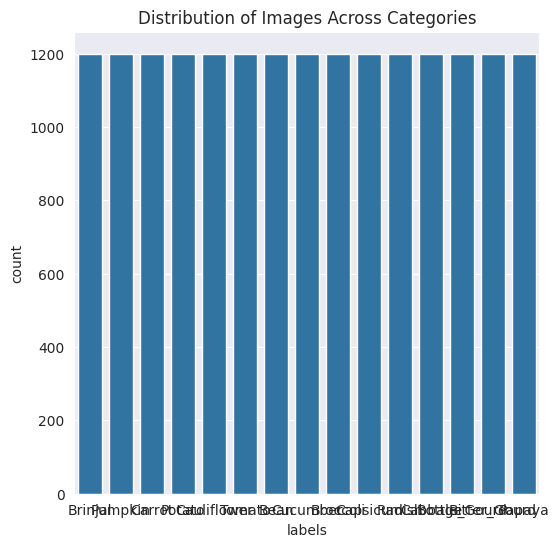

In [ ]:
# Create a dataframe to store image paths and labels
file_name = []
labels = []
full_path = []

# Loop through the dataset directory and get filenames, labels
for path, subdirs, files in os.walk(images_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split(os.sep)[-1])  # Extract the label from the folder name
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot the distribution of images across the classes
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, x='labels')
plt.title('Distribution of Images Across Categories')
plt.show()

#### Split Dataset

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Vegetable Images/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Bean,1200
Bitter_Gourd,1200
Bottle_Gourd,1200
Brinjal,1200
Broccoli,1200
Cabbage,1200
Capsicum,1200
Carrot,1200
Cauliflower,1200


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 14400
test size 3600


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels      
test   Bean            273
       Bitter_Gourd    232
       Bottle_Gourd    251
       Brinjal         243
       Broccoli        237
       Cabbage         247
       Capsicum        246
       Carrot          229
       Cauliflower     235
       Cucumber        235
       Papaya          216
       Potato          231
       Pumpkin         222
       Radish          253
       Tomato          250
train  Bean            927
       Bitter_Gourd    968
       Bottle_Gourd    949
       Brinjal         957
       Broccoli        963
       Cabbage         953
       Capsicum        954
       Carrot          971
       Cauliflower     965
       Cucumber        965
       Papaya          984
       Potato          969
       Pumpkin         978
       Radish          947
       Tomato          950
dtype: int64 


                                                 path        labels    set
8319       Vegetable Images/dataset/Broccoli/0710.jpg      Broccoli  train
449

In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Vegetable Images/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Define categories for train and test datasets
categories = [
    'Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage',
    'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin',
    'Radish', 'Tomato'
]

# Create directories for each category in both train and test sets
train_dirs = {category: os.path.join(TRAIN_DIR, category) for category in categories}
test_dirs = {category: os.path.join(TEST_DIR, category) for category in categories}

# Print total number of images in each category for train and test sets
for category in categories:
    print(f"Total number of {category} images in training set: ", len(os.listdir(train_dirs[category])))
    print(f"Total number of {category} images in test set: ", len(os.listdir(test_dirs[category])))

Total number of Bean images in training set:  927
Total number of Bean images in test set:  273
Total number of Bitter_Gourd images in training set:  968
Total number of Bitter_Gourd images in test set:  232
Total number of Bottle_Gourd images in training set:  949
Total number of Bottle_Gourd images in test set:  251
Total number of Brinjal images in training set:  957
Total number of Brinjal images in test set:  243
Total number of Broccoli images in training set:  963
Total number of Broccoli images in test set:  237
Total number of Cabbage images in training set:  953
Total number of Cabbage images in test set:  247
Total number of Capsicum images in training set:  954
Total number of Capsicum images in test set:  246
Total number of Carrot images in training set:  971
Total number of Carrot images in test set:  229
Total number of Cauliflower images in training set:  965
Total number of Cauliflower images in test set:  235
Total number of Cucumber images in training set:  965
Tota

In [ ]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.2)  # Membagi data untuk training dan validation

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Train data generator untuk pelatihan
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator untuk validasi
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test data generator untuk pengujian
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 11527 images belonging to 15 classes.
Found 2873 images belonging to 15 classes.
Found 3600 images belonging to 15 classes.


## Modelling

### Model Exp 1 - CNN Architecture (32 Neurons in Conv Layer)

In [ ]:
# Model CNN menggunakan Sequential
model_1 = Sequential()

# 1st Convolutional layer, Batch Normalization, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))  # Menggunakan 3 saluran warna RGB
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1st Dense Layer
model_1.add(Dense(128, activation='relu'))
# 1st Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation='relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer for output prediction
model_1.add(Dense(15, activation='softmax'))

# Compile model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404,367 (5.36 MB)

 Trainable params: 1,404,175 (5.36 MB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
categories = os.listdir('Vegetable Images/dataset/')
count_classes = {category: len(os.listdir(os.path.join('Vegetable Images/dataset/', category))) for category in categories}

total_images = sum(count_classes.values())
class_weights = {i: (1 / count) * (total_images / len(categories)) for i, (category, count) in enumerate(count_classes.items())}
print("Class weights:", class_weights)

# Fitting / Training Model
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights
)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.1999 - loss: 3.1058 - val_accuracy: 0.1789 - val_loss: 4.3836
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4630 - loss: 1.7942 - val_accuracy: 0.6669 - val_loss: 1.0855
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.5830 - loss: 1.4099 - val_accuracy: 0.7783 - val_loss: 0.7734
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6641 - loss: 1.1341 - val_accuracy: 0.6352 - val_loss: 2.1156
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.7015 - loss: 1.0048 - val_accuracy: 0.7379 - val_loss: 1.1485
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.7486 - loss: 0.8894 - val_accuracy: 0.7163 - val_loss: 1.0394
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.7643 - loss

### Model Exp 2 - CNN Architecture Using 64 Neurons in Conv Layer with Adam Optimizer

In [ ]:
# tf.keras.backend.clear_session()
model_2 = Sequential()

# 1st Convolutional layer, Batch Normalization, and Pooling layer
model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling layer
model_2.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Flatten layer
model_2.add(Flatten())

# 1st Dense Layer
model_2.add(Dense(128, activation='relu'))

# 1st Dropout Layer
model_2.add(Dropout(0.3))

# 2nd Dense Layer
model_2.add(Dense(64, activation='relu'))

# 2nd Dropout Layer
model_2.add(Dropout(0.2))

# Final Dense layer for output prediction
model_2.add(Dense(15, activation='softmax'))

# Compile model with Adam optimizer and lower learning rate
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_2.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,292,111 (43.08 MB)

 Trainable params: 11,291,855 (43.08 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [ ]:
categories = os.listdir('Vegetable Images/dataset/')  # Kategori kelas sayuran
count_classes = {category: len(os.listdir(os.path.join('Vegetable Images/dataset/', category))) for category in categories}

total_images = sum(count_classes.values())
class_weights = {i: (1 / count) * (total_images / len(categories)) for i, (category, count) in enumerate(count_classes.items())}
print("Class weights:", class_weights)

# Melatih model dengan data training menggunakan class_weights yang dihitung
history_2 = model_2.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights
)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.3529 - loss: 2.2611 - val_accuracy: 0.0794 - val_loss: 10.9285
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6460 - loss: 1.1675 - val_accuracy: 0.7999 - val_loss: 0.6800
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.7462 - loss: 0.8105 - val_accuracy: 0.8803 - val_loss: 0.4279
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.8279 - loss: 0.5825 - val_accuracy: 0.9001 - val_loss: 0.4016
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.8529 - loss: 0.4864 - val_accuracy: 0.9241 - val_loss: 0.2843
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8791 - loss: 0.4155 - val_accuracy: 0.9297 - val_loss: 0.2700
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8945 - los

### Model Exp 3 - CNN Architecture Using 64 Neurons in Conv Layer with Callback (early stopping)

In [ ]:
# tf.keras.backend.clear_session()
model_3 = Sequential()

# 1st Convolutional layer, Batch Normalization, and Poling layer
model_3.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling layer
model_3.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization, and Pooling layer
model_3.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten layer
model_3.add(Flatten())

# 1st Dense Layer
model_3.add(Dense(128, activation='relu'))

# 1st Dropout Layer
model_3.add(Dropout(0.3))

# 2nd Dense Layer
model_3.add(Dense(64, activation='relu'))

# 2nd Dropout Layer
model_3.add(Dropout(0.2))

# Final Dense layer for output prediction
model_3.add(Dense(15, activation='softmax'))

# Compile model with Adam optimizer and lower learning rate
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
categories = os.listdir('Vegetable Images/dataset/')
count_classes = {category: len(os.listdir(os.path.join('Vegetable Images/dataset/', category))) for category in categories}

total_images = sum(count_classes.values())
class_weights = {i: (1 / count) * (total_images / len(categories)) for i, (category, count) in enumerate(count_classes.items())}
print("Class weights:", class_weights)

# Preparing callback
# EarlyStopping: Stop training if no improvement after a certain number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint: Save the best model based on validation loss
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Melatih model dengan data training menggunakan class_weights dan callback
history_3 = model_3.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]  # Apply callbacks
)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3792 - loss: 2.0678

361/361 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.3796 - loss: 2.0665 - val_accuracy: 0.3046 - val_loss: 2.5845
Epoch 2/30
360/361 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7374 - loss: 0.8300

361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.7376 - loss: 0.8296 - val_accuracy: 0.8991 - val_loss: 0.3337
Epoch 3/30
360/361 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8463 - loss: 0.5002

361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8463 - loss: 0.5000 - val_accuracy: 0.9269 - val_loss: 0.2528
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8892 - loss: 0.3583 - val_accuracy: 0.9227 - val_loss: 0.2632
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9137 - loss: 0.2735

361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9137 - loss: 0.2735 - val_accuracy: 0.9561 - val_loss: 0.1513
Epoch 6/30
360/361 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9377 - loss: 0.2002

361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9377 - loss: 0.2002 - val_accuracy: 0.9662 - val_loss: 0.1314
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9562 - loss: 0.1441

361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9562 - loss: 0.1441 - val_accuracy: 0.9579 - val_loss: 0.1237
Epoch 8/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9537 - loss: 0.1518

361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9537 - loss: 0.1518 - val_accuracy: 0.9676 - val_loss: 0.1139
Epoch 9/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9599 - loss: 0.1405 - val_accuracy: 0.9561 - val_loss: 0.1697
Epoch 10/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9668 - loss: 0.1172 - val_accuracy: 0.9694 - val_loss: 0.1140
Epoch 11/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9714 - loss: 0.0917 - val_accuracy: 0.9662 - val_loss: 0.1330
Epoch 12/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9699 - loss: 0.0910 - val_accuracy: 0.9641 - val_loss: 0.1391
Epoch 13/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9758 - loss: 0.0797 - val_accuracy: 0.9687 - val_loss: 0.1441


## Evaluasi dan Visualisasi

### Model Exp 1 - CNN Architecture (32 Neurons in Conv Layer)

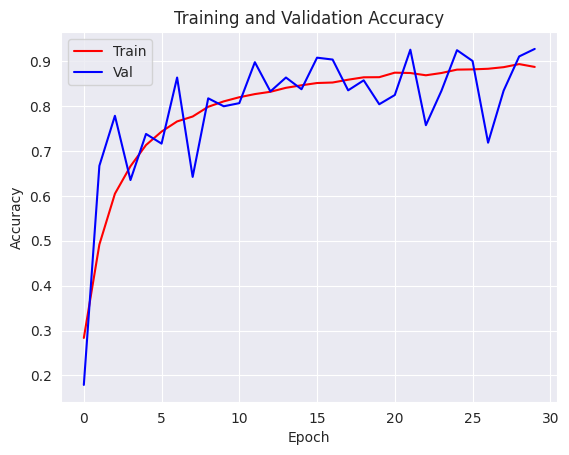

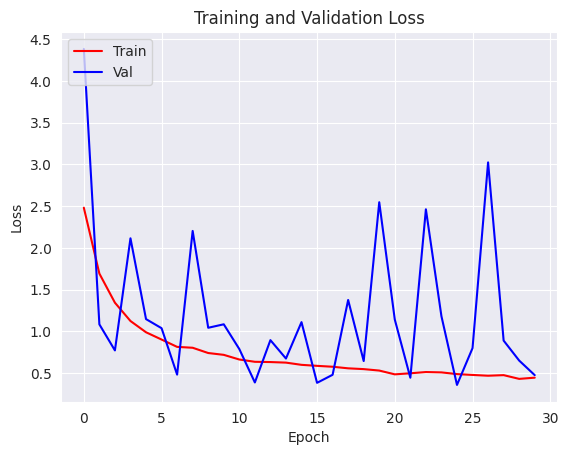

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

# Plotting Training and Validation Accuracy
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Reset test generator
test_generator.reset()

# Prediksi dengan model
preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, preds_1, target_names=list(test_generator.class_indices.keys()), digits=4))


Classification Report:

              precision    recall  f1-score   support

        Bean     0.9382    0.8901    0.9135       273
Bitter_Gourd     0.9912    0.9698    0.9804       232
Bottle_Gourd     0.9838    0.9681    0.9759       251
     Brinjal     0.9258    0.8724    0.8983       243
    Broccoli     0.9907    0.9030    0.9448       237
     Cabbage     0.9612    0.8016    0.8742       247
    Capsicum     0.9268    0.9268    0.9268       246
      Carrot     0.9765    0.9083    0.9412       229
 Cauliflower     0.9440    0.9319    0.9379       235
    Cucumber     0.9234    0.8723    0.8972       235
      Papaya     0.9134    0.9769    0.9441       216
      Potato     0.8085    0.9870    0.8889       231
     Pumpkin     0.9679    0.9505    0.9591       222
      Radish     0.9432    0.9842    0.9632       253
      Tomato     0.7597    0.9360    0.8387       250

    accuracy                         0.9244      3600
   macro avg     0.9303    0.9253    0.9256      3600
w

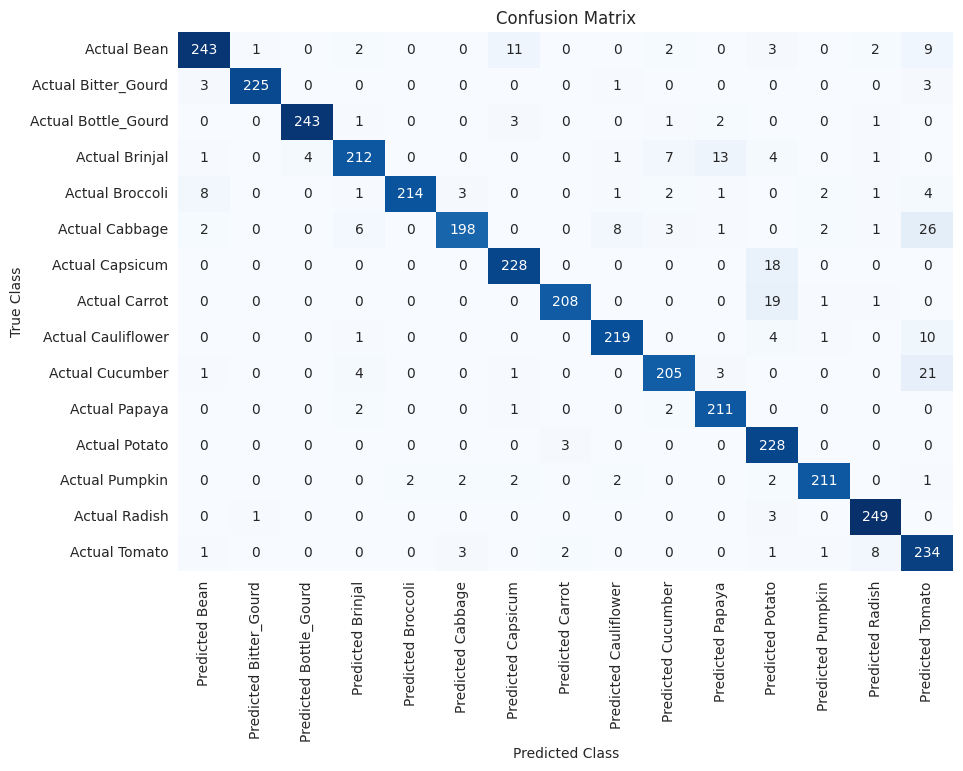

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_1, labels=np.arange(15)),
    index=[f"Actual {cls}" for cls in test_generator.class_indices.keys()],
    columns=[f"Predicted {cls}" for cls in test_generator.class_indices.keys()]
)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### Model Exp 2 - CNN Architecture Using 64 Neurons in Conv Layer with Adam Optimizer

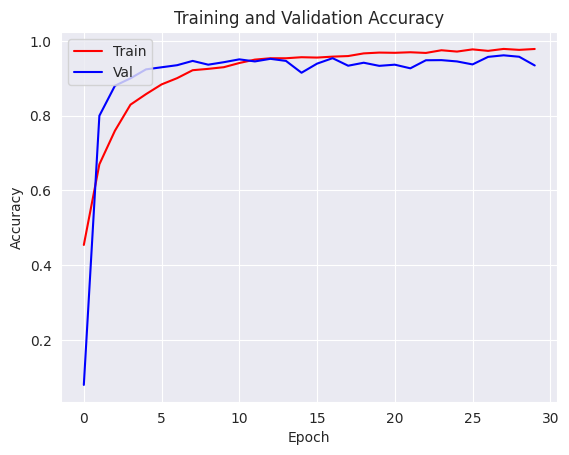

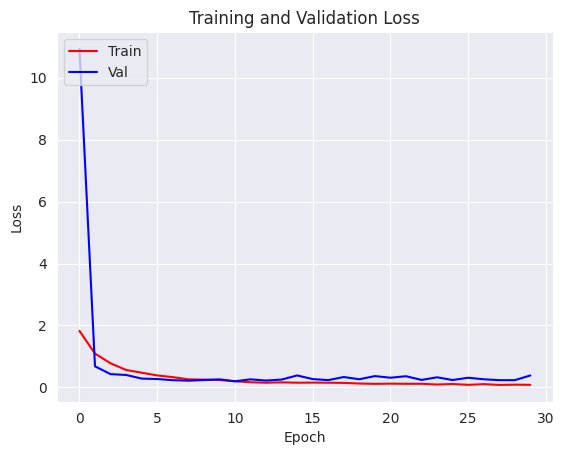

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

# Plotting Training and Validation Accuracy
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_generator.reset()

# Prediksi dengan model
preds_2 = model_2.predict(test_generator, verbose=0)
preds_2 = np.argmax(preds_2, axis=1)

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, preds_2, target_names=list(test_generator.class_indices.keys()), digits=4))


Classification Report:

              precision    recall  f1-score   support

        Bean     0.9559    0.9524    0.9541       273
Bitter_Gourd     0.8652    0.9957    0.9259       232
Bottle_Gourd     0.9878    0.9641    0.9758       251
     Brinjal     0.9852    0.8230    0.8969       243
    Broccoli     0.9120    0.9620    0.9363       237
     Cabbage     0.9689    0.6316    0.7647       247
    Capsicum     0.9798    0.9837    0.9817       246
      Carrot     0.9463    1.0000    0.9724       229
 Cauliflower     0.8490    0.8851    0.8667       235
    Cucumber     0.9303    0.9660    0.9478       235
      Papaya     0.9170    0.9722    0.9438       216
      Potato     0.8780    0.9654    0.9196       231
     Pumpkin     0.8979    0.9505    0.9234       222
      Radish     0.9504    0.9842    0.9670       253
      Tomato     0.9344    0.9120    0.9231       250

    accuracy                         0.9289      3600
   macro avg     0.9305    0.9299    0.9266      3600
w

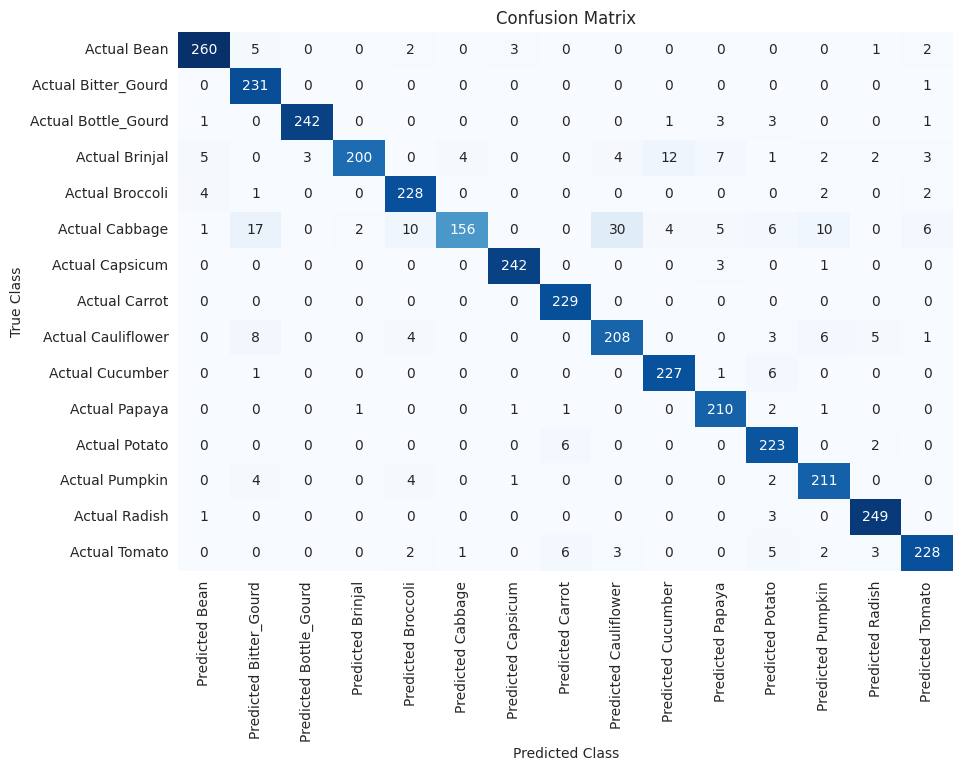

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_2, labels=np.arange(15)),  # Menggunakan 15 kelas
    index=[f"Actual {cls}" for cls in test_generator.class_indices.keys()],
    columns=[f"Predicted {cls}" for cls in test_generator.class_indices.keys()]
)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### Model Exp 3 - CNN Architecture Using 64 Neurons in Conv Layer with Callback (early stopping)

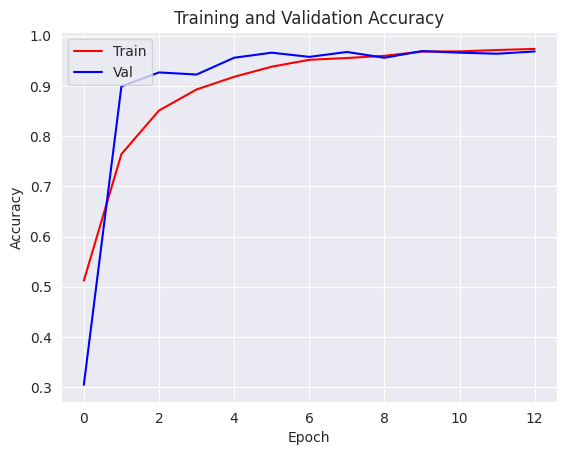

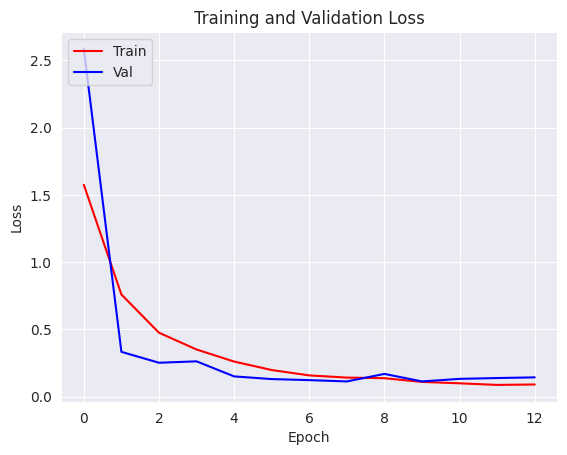

In [ ]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

# Plotting Training and Validation Accuracy
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Reset test generator
test_generator.reset()

# Prediksi dengan model
preds_3 = model_3.predict(test_generator, verbose=0)
preds_3 = np.argmax(preds_3, axis=1)

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, preds_3, target_names=list(test_generator.class_indices.keys()), digits=4))


Classification Report:

              precision    recall  f1-score   support

        Bean     0.9923    0.9451    0.9681       273
Bitter_Gourd     0.9625    0.9957    0.9788       232
Bottle_Gourd     0.9881    0.9920    0.9901       251
     Brinjal     0.9781    0.9177    0.9469       243
    Broccoli     0.9667    0.9789    0.9727       237
     Cabbage     0.9129    0.9757    0.9432       247
    Capsicum     0.9800    0.9959    0.9879       246
      Carrot     0.9870    0.9956    0.9913       229
 Cauliflower     0.9283    0.9915    0.9588       235
    Cucumber     0.9344    0.9702    0.9520       235
      Papaya     0.9815    0.9815    0.9815       216
      Potato     1.0000    0.9740    0.9868       231
     Pumpkin     0.9819    0.9775    0.9797       222
      Radish     0.9842    0.9842    0.9842       253
      Tomato     0.9911    0.8920    0.9389       250

    accuracy                         0.9706      3600
   macro avg     0.9713    0.9712    0.9707      3600
w

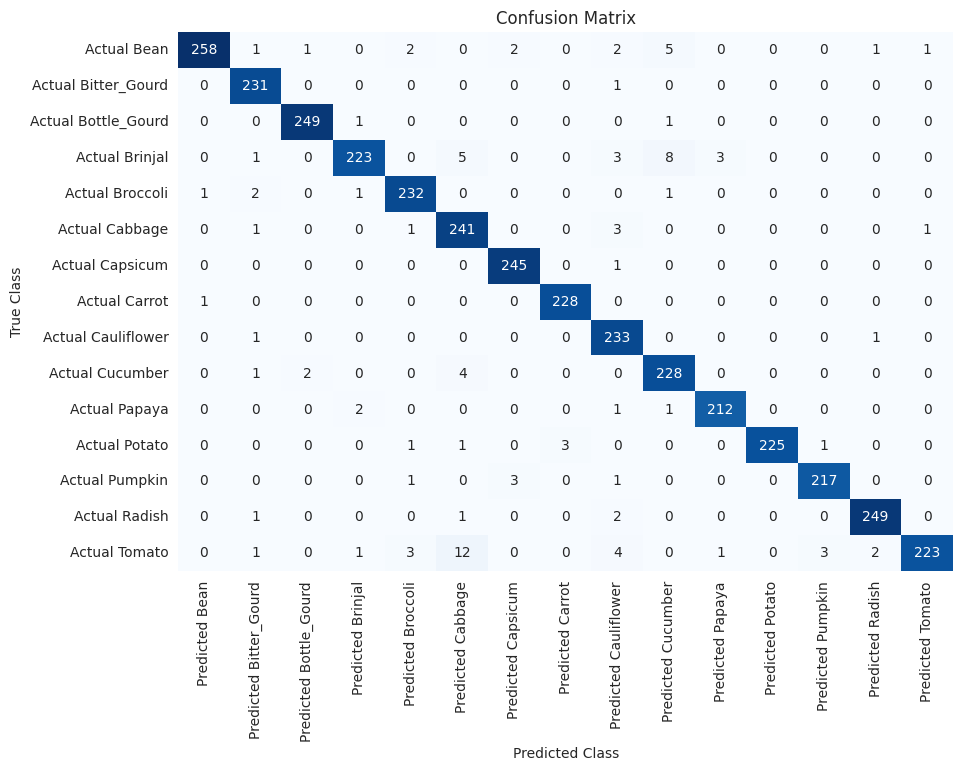

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_3, labels=np.arange(15)),  # Menggunakan 15 kelas
    index=[f"Actual {cls}" for cls in test_generator.class_indices.keys()],
    columns=[f"Predicted {cls}" for cls in test_generator.class_indices.keys()]
)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()